In [1]:
from tkinter import *
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [2]:
def get_dataframe(path_file,cols):
    return pd.read_csv(path_file, sep=',', names=cols, encoding='utf-8')

In [3]:
def show_table(matrix1,matrix2,X,y,name_table="Matrix"):
    plt.imshow(np.isnan(matrix1), cmap='Reds', interpolation='nearest', alpha=0.3)
    plt.imshow(matrix1, cmap='viridis', interpolation='nearest', alpha=0)
    for i in range(len(y)):
        for j in range(len(X)):
            if not np.isnan(matrix2[i, j]):
                plt.text(j, i, str(np.round(matrix2[i, j],2)), ha='center', va='center', color='black',fontsize=10) 
            else:
                plt.text(j, i, "?", ha='center', va='center', color='red',fontsize=12)

    plt.xlabel('user_id')
    plt.ylabel('item_id')
    plt.title(name_table)
    plt.show()

[0 1 2 3 4 5 6]
[0 1 2 3 4]


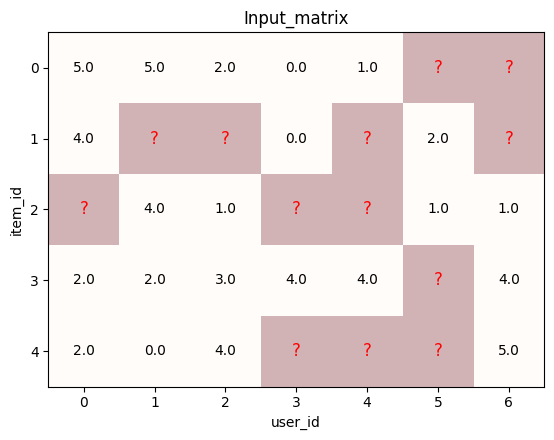

In [4]:
cols_rating = ['user_id', 'item_id', 'rating']
data_ratings = get_dataframe('./DataPredict/user_base_ratings.csv', cols_rating)

X = np.sort(data_ratings['user_id'].unique())
y = np.sort(data_ratings['item_id'].unique())
print(X)
print(y)

matrix_ratings = []
for i in X:
    row = []
    for j in y:
        rating = data_ratings[(data_ratings['user_id'] == i) & (data_ratings['item_id'] == j)]['rating']
        if rating.empty:
            row.append(np.nan)  
        else:
            row.append(float(rating.values[0])) 
    matrix_ratings.append(row)

matrix_ratings = np.array(matrix_ratings).T

show_table(matrix_ratings,matrix_ratings,X,y,"Input_matrix")

In [5]:
mean_users = np.nanmean(matrix_ratings, axis=0)
mean_users

array([3.25      , 2.75      , 2.5       , 1.33333333, 2.5       ,
       1.5       , 3.33333333])

Chuẩn hóa ma trận

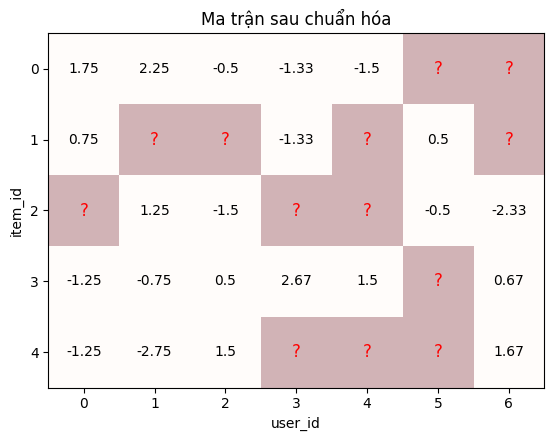

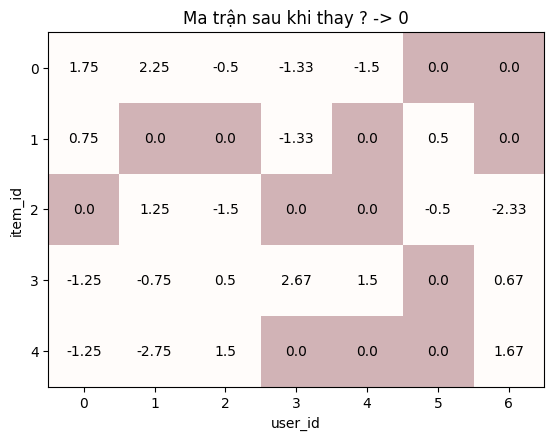

In [6]:
normalize_matrix = np.empty_like(matrix_ratings)
for i in range(matrix_ratings.shape[1]):
    user = matrix_ratings[:, i]
    mean_user = mean_users[i]
    normalize_matrix[:, i] = user - mean_user
show_table(matrix_ratings,normalize_matrix,X,y,"Ma trận sau chuẩn hóa")
normalize_matrix[np.isnan(normalize_matrix)] = 0
show_table(matrix_ratings,normalize_matrix,X,y,"Ma trận sau khi thay ? -> 0")


tính toán độ tương đồng

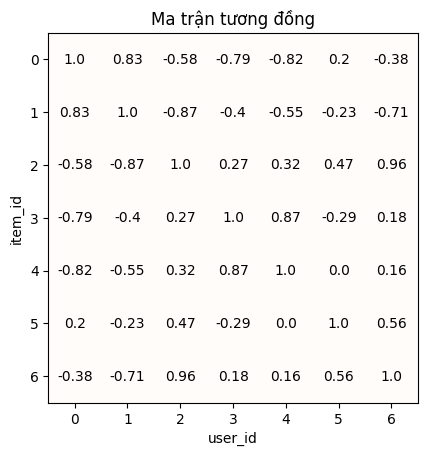

In [7]:
similarity_matrix = cosine_similarity(normalize_matrix.T)
show_table(similarity_matrix,similarity_matrix,X,X,"Ma trận tương đồng")

ma trận dự đoán

In [8]:
def predict_matrix(normalize_matrix,similarity_matrix, K):
    num_users, num_items = normalize_matrix.shape
    pred_matrix = np.zeros((num_users, num_items))
    
    for item_idx in range(num_items):
        rated_users = np.nonzero(normalize_matrix[:, item_idx])[0]  # Danh sách các users đã rated cho item_idx
        
        for user_idx in range(num_users):
            if normalize_matrix[user_idx, item_idx] == 0:  # Nếu user_idx chưa rated cho item_idx
                similarity_values = similarity_matrix[user_idx, rated_users]  # Giá trị similarities của user_idx với các users đã rated
                top_K_indices = np.argsort(-similarity_values)[:K]  # Chọn K giá trị lớn nhất
                top_K_values = similarity_values[top_K_indices]  # Giá trị similarities của K users có similarities lớn nhất
                normalized_ratings = normalize_matrix[rated_users[top_K_indices], item_idx]  # Ratings normalized của K users
                
                # Tính pred rating cho user_idx và item_idx
                pred_rating = np.dot(top_K_values, normalized_ratings) / np.sum(np.abs(top_K_values))
                pred_matrix[user_idx, item_idx] = pred_rating
    
    return pred_matrix

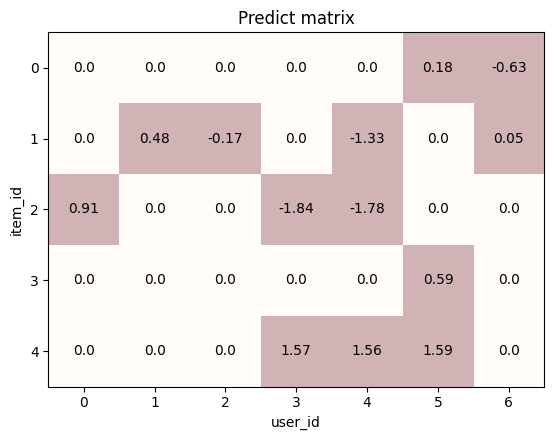

In [9]:
pred_matrix = predict_matrix(normalize_matrix.T,similarity_matrix,2).T
show_table(matrix_ratings,pred_matrix,X,y,"Predict matrix")

Hiển thị dự đoán từng người dùng

In [10]:
def get_recommendations(user_id, pred_matrix, ratings_matrix, item_titles):
    # Xác định các sản phẩm chưa được user_id đánh giá (có giá trị NaN)
    unrated_items_indices = np.where(np.isnan(ratings_matrix[user_id]))[0]
    print(unrated_items_indices)
    # Tính toán pred ratings cho user_id cho các sản phẩm chưa đánh giá
    pred_ratings = pred_matrix[user_id, unrated_items_indices]
    print(pred_ratings)
    # Sắp xếp danh sách các bộ giá trị rating
    sorted_indices = np.argsort(pred_ratings)[::-1]
    print(sorted_indices)
    print(unrated_items_indices[sorted_indices])
    # Trả về các tiêu đề tương ứng với chỉ số của các phần tử trên cùng
    recommended_titles = [item_titles[item_idx] for item_idx in unrated_items_indices[sorted_indices]]
    
    return recommended_titles

In [11]:
item_titles = ['Product A', 'Product B', 'Product C', 'Product D',"Product E"]
user_id = 4
# Lấy các tiêu đề sản phẩm được đề xuất cho user_id
recommended_titles = get_recommendations(user_id, pred_matrix.T, matrix_ratings.T, item_titles)
print(recommended_titles)

[1 2 4]
[-1.33333333 -1.78012694  1.55602539]
[2 0 1]
[4 1 2]
['Product E', 'Product B', 'Product C']


In [12]:

# cf_rs = CF(data_matrix, k=2, uuCF=1)
# cf_rs.fit()

# cb_rs = CB('./recommendation-system-master/dataset/movilens_csv/movies.csv')
# cb_rs.fit()

# list_name_movie = get_name_movie('./recommendation-system-master/dataset/ml-100k/u.item')
# list_year_movie = get_year_movie('./recommendation-system-master/dataset/ml-100k/u.item')
# gui(cf_rs, cb_rs, list_name_movie, list_year_movie)

